# Projeto 1 - Confiabilidade

## Código

Todo o código (incluindo esse notebook) se encontram no repositório:

<https://github.com/DanielHLelis/PROJ1-STAT>

<img src="assets/QR.svg" style="width:300px;"/>

## Orientações

Boa parte do código fonte foi organizado dentro de um módulo chamado `common`, disponibilizado juntamente ao notebook.
Alguns tópicos de atenção:

- **Dependências**
  - Neste notebook tem um bloco de código comentado que serve para instalar automaticamente as dependências, recomenda-se
    criar um ambiente virtual e instalá-las desta forma.
  - Caso crie uma venv, não esqueça de instalar o `jupyter` e/ou `ipykernel`.
  - **Importante:** *Nem todas as dependências utilizadas são comumente disponibilizadas
    em ambientes de execução como Google Colaboratory ou Anaconda.*
- **Configuração**
  - Caso seja necessário, é possível adequar algumas configurações para seu ambiente de execução (verificar `common/consts.py`
    e o bloco *"Configuração"*)
- **Simulações**
  - Por questões de performance, testamos desenvolver o simulador em algumas tecnologias. A versão mais completa e performática
    é a feita em *rust*, disponível em `/simulators/rust`, porém a versão em *Python*, principalmente usando *pypy*, consegue
    "quebrar o galho", estando disponível em `/simulators/python`.
  - Os resultados das simulações são armazenados em arquivos `.json` dentro da pasta `/datasets`. O notebook pode chamar os simuladores
    para gerar novas simulações caso não exista uma simulação com os parâmetros determinados. O simulador utilizado pode ser definido
    através das configurações.

Para compilar o simulador em Rust é necessário ter o gerenciador de pacotes do Rust (Cargo) instalado. [Guia de instalação](https://www.rust-lang.org/tools/install).

Tendo isso, basta entrar na pasta do simulador (`/simulators/rust`) e rodar o comando: `cargo build --release`.

### Dependências

In [1]:
# Instalação de dependências (descomentar linhas abaixo para instalar)
import sys

# !"{sys.executable}" -m pip install --upgrade pip
# !"{sys.executable}" -m pip install --upgrade pandas
# !"{sys.executable}" -m pip install --upgrade numpy
# !"{sys.executable}" -m pip install --upgrade scipy
# !"{sys.executable}" -m pip install --upgrade sympy
# !"{sys.executable}" -m pip install --upgrade matplotlib
# !"{sys.executable}" -m pip install --upgrade seaborn
# !"{sys.executable}" -m pip install --upgrade plotly
# !"{sys.executable}" -m pip install --upgrade statsmodels

In [2]:
# Carregamento das dependências utilizadas

import sys
import os
import json
import math
import collections
import importlib

import numpy as np
import scipy as sc
import scipy.stats as st
import sympy as sp
import pandas as pd
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from typing import List, Tuple, Callable, Dict

import statsmodels.api as sm
import pylab as py

# Biblioteca interna
from common.models import tnbinom, WrappedPPF # Solução analítica
from common.simulation import load_or_generate_simulation, build_pmf, sim_s_search, normalized_results # Simulação

plt.style.use('dark_background')

### Constantes

Verificar o arquivo `common/consts.py` para mais detalhes.

### Utilidades

Verificar os códigos em `common/` para mais detalhes.

## Enunciado

### Projeto 1 - Confiabilidade

Um sistema requer $n$ máquinas para funcionar. Elas quebram, a cada unidade de tempo (um minuto), com
probabilidade $p_0$. Para garantir o funcionamento confiável do sistema, $s$ máquinas adicionais são mantidas para
reposição. Quando uma máquina quebra, ela é substituída por uma em bom estado e enviada para reparo. O
tempo de reparo de cada máquina  ́e $t_R$ (fixo).

Deseja-se estudar a variável aleatória “tempo de colapso” do sistema, isto  ́e, o tempo $T$ que o sistema funciona
até dever ser parado porque não há $n$ máquinas disponíveis. Quanto vale $E(T)$? Qual é a distribuição de $T$?
Como depende a variável $T$ do número de máquinas reserva $s$? Mais em concreto, quantas máquinas adicionais
são necessárias para que $\text{Prob}\{T < 10000\}$ seja menor que 1%?

Faixas sugeridas de valores: $n = 10 − 100$, $p_0 = 0.001 − 0.01$, $s = 10 − 100$.

1. Quais das perguntas acima conseguem responder analiticamente? Nos casos que possa, qual é o resultado?
2. Os resultados do simulador são consistentes com as estimações analíticas no caso $\beta = 0$?
3. No simulador, é fácil inserir a amostragem de outras variáveis aleatórias. Estudar por exemplo a variável $Z$ que
podemos chamar “tempo de alerta”, definido como o tempo em que o número de máquinas em reparação atinge
80% do valor disponível $s$ (ou outra porcentagem a escolher). Como é a distribuição de probabilidade de $Z$?
4. São $Z$ e $T$ variáveis independentes? É possível predizer em alguma medida o tempo de colapso uma vez que foi
atingido o tempo de alerta? Se uma parada ordenada do sistema requer o tempo $t_R$ , pode sugerir uma estratégia
de manejo que “garanta” chegar a parada ordenada com 99% de probabilidade?
1. É lógico que as máquinas envelheçam. A probabilidade de cada máquina de falhar pode crescer linearmente com
o tempo, seguindo $p(k) = p_0 + \beta t_{f}(k)$ onde $k$ identifica a máquina e $t_f(k)$ o tempo que ela leva em funcionamento
desde o  ́ultimo reparo. No caso de $β \ne 0$  ́e impossível realizar cálculos analíticos sobre a variável $T$. Para isto,
desenvolver um pequeno código de simulação do processo. Esse caso é mais complexo que o original, porque é
necessário armazenar informação específica para cada máquina (o tempo que leva trabalhando). Mesmo assim,
trata-se apenas de uma adequada combinação de variáveis Bernoulli que o computador sabe simular.

## Parte 1 - Modelo Analítico e Validação da Simulação

### Uma simplificação do problema

Para encontrarmos uma solução analítica do problema, sentimos a necessidade de fazer algumas simplificações no problema, sendo elas: $t_R = \infty$ e $\beta = 0$. Dadas essas simplificações, conseguimos modelar nosso problema na forma de uma distribuição binomial negativa.

A representação mais comum da binomial negativa é dada por:

$$
p_1(t; s, p) = \begin{pmatrix}t + s - 1 \\ s -1\end{pmatrix} p^{s} (1 - p)^{t}
$$

Essa representação mede, dado um número fixo $s$ de sucessos desejados e uma probabilidade $p$, a probabilidade de obtermos $t$ falhas até atingir o último sucesso desejado.

Sabendo disso, podemos fazer algumas adaptações para melhor encaixá-la no problema. Primeiramente, ao invés de medirmos o número de falhas, vamos medir o número total de eventos necessários. Além disso, estamos interessados no ponto crítico do sistema, ou seja, quando atingimos $s_0 + 1$ falhas:

$$
p_2(t; s_0, p) = p_1(t-s_0-1; s_0 + 1, p) = \begin{pmatrix}t - 1 \\ s_0 \end{pmatrix} p^{s_0 + 1} (1 - p)^{t - s_0 - 1}
$$

Além disso, notemos que o problema considera um conjunto de $n$ máquinas em funcionamento de maneira simultânea. Podemos representar isso fazendo um agrupamento de $n$ eventos na nossa PMF, ficando da seguinte forma: ($k$ é o $k$-ésimo ciclo de execução)

$$
p_3(k; n, s_0, p) = \sum^{n}_{i = 1} p_2(n \cdot (k - 1) + i; s_0, p)
$$

Uma representação alternativa do formulado em $p_3$ é utilizando a CDF da binomial negativa, que, quando adequada ao nosso problema, pode ser representada da seguinte forma:

$$
I_{1-p}(s_0 + 1, k \cdot n - (s_0 + 1) + 1) = I_{1-p}(s_0 + 1, k \cdot n - s_0)
$$

*Obs.: $I$ corresponde à função beta incompleta regularizada* 

Além disso, o valor estimado pode ser representado da seguinte forma:

$$
E = \left[\frac{(1 - p)(s_0 + 1)}{p} + (s_0 + 1)\right] \cdot \frac{1}{n}
$$

#### A Variável $Z$ (Tempo de Alerta)

Dentro das mesmas simplificações, conseguimos mostrar que a modelagem da variável $Z$ seguirá a mesma distribuição, só que que com $s_0' = \lceil 0.8 \cdot s_0 \rceil$. Uma ideia semelhante se aplica ao tempo esperado de colapso.

### Comparando a solução analítica com a simulação



In [3]:
def compare_model_and_sim(n: int, s: int, p: float):
    # Simulation
    sim_data = load_or_generate_simulation(1000000, n, p, s) # Load simulation data
    xs, sim_ys =  build_pmf(sim_data) # Build simulation PMF
    simulation_trace = go.Bar(name="Simulação", x=xs, y=sim_ys) # Create simulation plot

    # Model
    model_ys = tnbinom.pmf(xs, n, s, p) # Compute PMF for model at xs
    model_trace = go.Bar(name="Modelo", x=xs, y=model_ys) # Create model plot
    
    # Mean
    simulation_mean = np.mean(sim_data['results'])
    model_mean = tnbinom.mean(n, s, p)

    # Z Variable
    z_xs, sim_z_ys = build_pmf(sim_data, field='results_z')
    simulation_z_trace = go.Bar(name="Simulação Z", x=z_xs, y=sim_z_ys, visible='legendonly') # Create simulation plot for Z

    model_z_ys = tnbinom.pmf(z_xs, n, np.ceil(s * 0.8), p)
    model_z_trace = go.Bar(name="Modelo Z", x=z_xs, y=model_z_ys, visible='legendonly') # Create simulation plot for Z

    # Z-delta Variable
    delta_xs, sim_delta_ys = build_pmf(sim_data, field='results_delta')
    simulation_delta_trace = go.Bar(name="Simulação Delta", x=delta_xs, y=sim_delta_ys, visible='legendonly') 

    model_delta_ys = tnbinom.pmf(delta_xs, n, s - np.ceil(s * 0.8) - 1, p)
    model_delta_trace = go.Bar(name="Modelo Delta", x=delta_xs, y=model_delta_ys, visible='legendonly')

    # Create plot figure
    fig = go.Figure(data=[
        simulation_trace,
        model_trace,
        simulation_z_trace,
        model_z_trace,
        simulation_delta_trace,
        model_delta_trace,
    ])

    # Add mean v-line
    fig.add_vline(x=simulation_mean, line_width=3, line_dash="dash", line_color="orange", annotation_text='Valor esperado')

    # Customize plot
    fig.update_layout(barmode="group", title={
        'text': f"Modelo x Simulação: n={n}; s={s}; p={p}",
        'xanchor': 'center',
        'x': 0.5
        },
        template="plotly_dark",
                      xaxis_title="Tempo (k)",
                      yaxis_title="Densidade de Probabilidade")
    fig.show()

In [4]:
compare_model_and_sim(50, 25, 0.005)
compare_model_and_sim(100, 25, 0.007)
compare_model_and_sim(100, 40, 0.01)

### Testes de Aderência e de Hipótese

#### Comparando Modelos às Simulações

Considere as seguintes configurações do sistema:

$$ 
    A: \quad n = 50 \quad p_0 = 0.005 \quad s_0 = 25
    \\
    B: \quad n = 100 \quad p_0 = 0.007 \quad s_0 = 25
    \\
    C: \quad n = 100 \quad p_0 = 0.01 \quad s_0 = 40
$$

In [5]:
params = [(50, 25, 0.005), (100, 25, 0.007), (100, 40, 0.01)]
simulations = [load_or_generate_simulation(1000000, p[0], p[2], p[1]) for p in params]

#### Comparando com uma normal (Q-Q Plot)

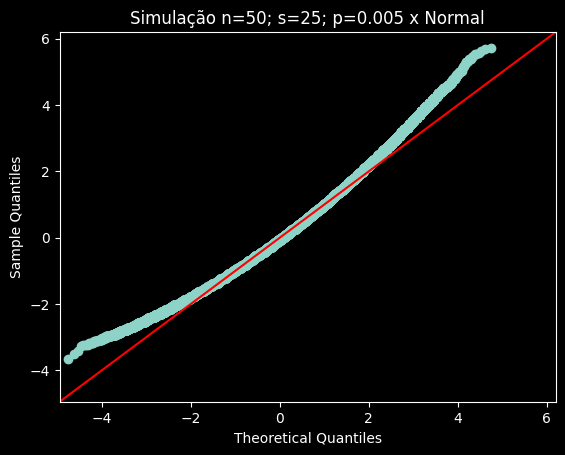

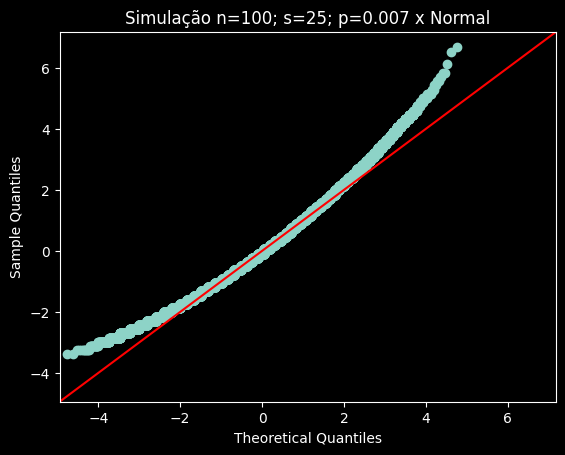

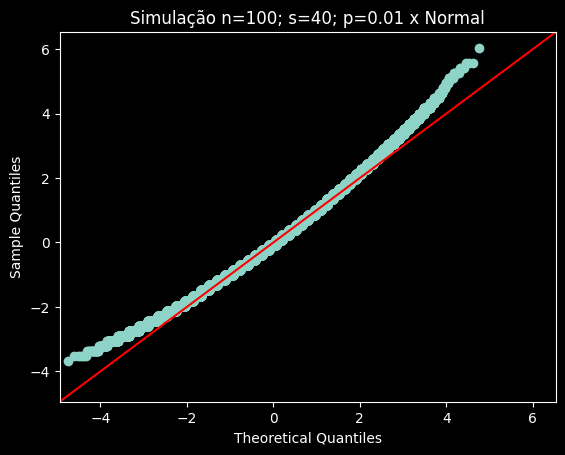

In [6]:

for i, param in enumerate(params):
    sim = simulations[i]
    sim_normalized = normalized_results(sim)
    sm.qqplot(sim_normalized, line ='45')
    plt.title(f'Simulação n={param[0]}; s={param[1]}; p={param[2]} x Normal')
py.show()

#### Conclusão Q-Q plot (Normal)

Os dados não seguem uma distribuição normal.

#### Comparando o modelo proposto (Q-Q plot)

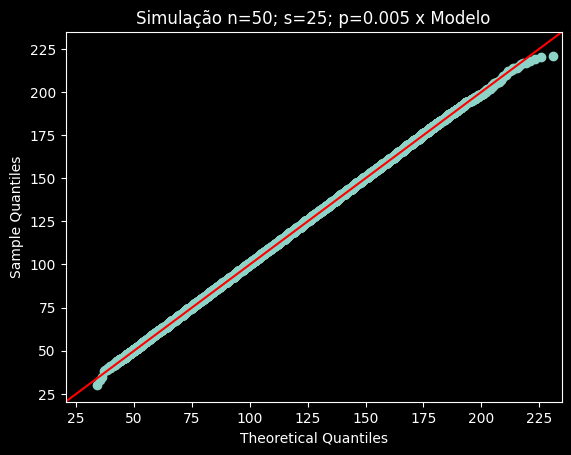

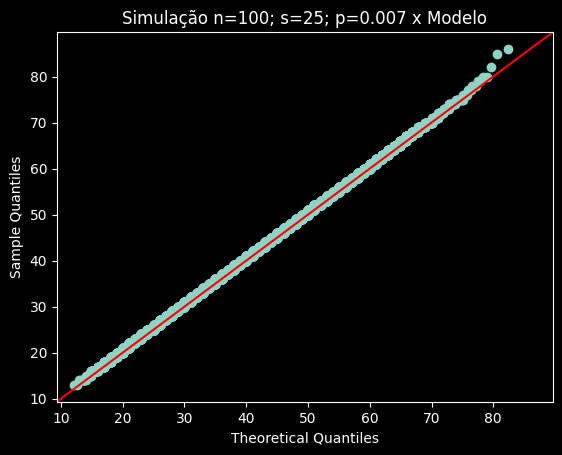

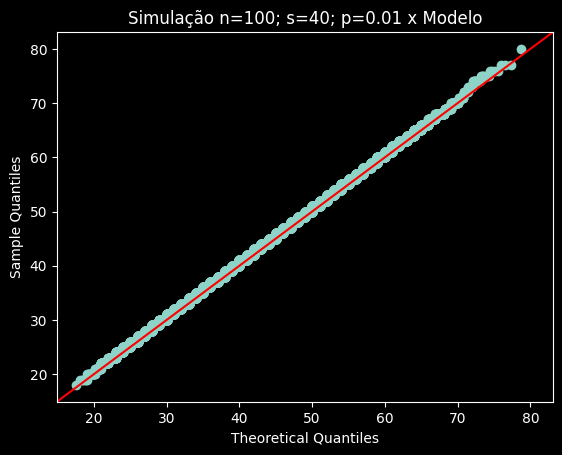

In [7]:
for i, param in enumerate(params):
    sim = simulations[i]
    sm.qqplot(np.array(sim['results']), dist=WrappedPPF(*param), line ='45')
    plt.title(f'Simulação n={param[0]}; s={param[1]}; p={param[2]} x Modelo')
py.show()

#### Conclusão Q-Q Plot (Modelo)

Os dados parecem seguir o modelo proposto (binomial negativa com agrupamento).

### Teste de Aderência Qui-Quadrado

Por termos uma distribuição discreta, optamos por usar o teste Qui-Quadrado de aderência.


In [8]:
def chisquare_test(simulation_data, model_pmf, bin_threshold=5):
    # Test low & high end
    low_end, high_end = 0, int(max(simulation_data) * 2)

    # Building frequency table
    sample_size = len(simulation_data)
    sim_value_count = pd.Series(simulation_data).value_counts()
    simulation_freq = {k: (sim_value_count[k] if k in sim_value_count else 0) for k in range(low_end, high_end + 1)}
    expected_freq = {k: model_pmf(k) * sample_size for k in range(low_end, high_end + 1)}

    # Create most optimal bins
    bins = []
    simulation_freq_binned = []
    expected_freq_binned = []

    prev_st = 0
    sim_cul = 0
    exp_cul = 0
    for i in range(low_end, high_end + 1):
        sim_cul += simulation_freq[i]
        exp_cul += expected_freq[i]

        if sim_cul >= bin_threshold:
            bins.append((prev_st, i))
            prev_st = i + 1

            simulation_freq_binned.append(sim_cul)
            expected_freq_binned.append(exp_cul)
            
            sim_cul = 0
            exp_cul = 0


    simulation_freq_binned[-1] += sim_cul
    expected_freq_binned[-1] += exp_cul
    bins[-1] = (bins[-1][0], high_end)

    # Do chisquare
    return st.chisquare(simulation_freq_binned, expected_freq_binned)

In [9]:
for i, param in enumerate(params):
    sim = simulations[i]
    stat, p = chisquare_test(sim['results'], tnbinom(*param).pmf, bin_threshold=10)
    print("=" * 40)
    print(f"Teste Qui-Quadrado n={param[0]}; s={param[1]}; p={param[2]}")
    print(f"Estatística do teste: {stat:.8f}")
    print(f"P-Valor: {p:.8f}")

Teste Qui-Quadrado n=50; s=25; p=0.005
Estatística do teste: 137.67526887
P-Valor: 0.91744677
Teste Qui-Quadrado n=100; s=25; p=0.007
Estatística do teste: 53.54405670
P-Valor: 0.76922686
Teste Qui-Quadrado n=100; s=40; p=0.01
Estatística do teste: 51.72930973
P-Valor: 0.56245805


#### Conclusão Aderência Qui-Quadrado

Devido aos p-valores altos, não há evidência para rejeitar a hipótese nula ($H_0:$ as simulações seguem o modelo proposto).

### Análise das médias

In [10]:
# Diferença constante entre amostra e modelo de ~0.48 (causa desconhecida)
for i, param in enumerate(params):
    sim = simulations[i]
    sim_mean = np.mean(sim['results'])
    model_mean = tnbinom.mean(*param)
    print("=" * 45)
    print(f"Média Amostra x Modelo - n={param[0]}; s={param[1]}; p={param[2]}")
    print(f"Simulação: {sim_mean}")
    print(f"Modelo: {model_mean}")

Média Amostra x Modelo - n=50; s=25; p=0.005
Simulação: 104.488596
Modelo: 104.0
Média Amostra x Modelo - n=100; s=25; p=0.007
Simulação: 37.621524
Modelo: 37.14285714285714
Média Amostra x Modelo - n=100; s=40; p=0.01
Simulação: 41.489636
Modelo: 41.0


Considerando uma média amostral $\overline x$, dado a média  teórica $\mu$. Como temos um tamanho amostral muito grande, podemos aplicar o teorema central do limite e assumir que 
$$\frac {\overline x - \mu} {\frac {\sigma} {\sqrt{N}}} \sim N(0, 1) $$

\begin{cases}
    h_0: \, \mu = \overline x 
    \\
    h_a: \, \mu \ne \overline x
\end{cases}

##### Teste de acordo com a média esperada do modelo

Rejeitamos a hipótese nula. Os p-valores são, praticamente, zero.

In [11]:
for i, param in enumerate(params):
    sim = simulations[i]
    sim_mean = np.mean(sim['results'])
    model_mean = tnbinom.mean(*param)
    sim_std = np.std(sim['results'], ddof=1) # Desvio padrão estimado

    z_value = ((model_mean - sim_mean) * np.sqrt(len(sim['results']))) / sim_std
    p_value = 2 * st.norm.cdf(-abs(z_value))
    
    print("=" * 45)
    print(f"Média Amostra x Modelo - n={param[0]}; s={param[1]}; p={param[2]}")
    print(f"Simulação: {sim_mean}")
    print(f"Modelo: {model_mean}")
    print(f"Estatística do teste: {z_value}")
    print(f"P-Valor: {p_value}")

Média Amostra x Modelo - n=50; s=25; p=0.005
Simulação: 104.488596
Modelo: 104.0
Estatística do teste: -24.01565621021647
P-Valor: 1.90829752806823e-127
Média Amostra x Modelo - n=100; s=25; p=0.007
Simulação: 37.621524
Modelo: 37.14285714285714
Estatística do teste: -65.99022866235521
P-Valor: 0.0
Média Amostra x Modelo - n=100; s=40; p=0.01
Simulação: 41.489636
Modelo: 41.0
Estatística do teste: -76.85190740054973
P-Valor: 0.0


#### Teste com a média corrigida a partir do observado

Ao corrigir a média pelo desvio que observamos nas amostras, aceitamos a hipótese nula. O que indica que o cálculo da esperança que apresentamos anteriormente não indica a história completa, porém parece se aproximar
ao inteiro mais próximo da média real da distribuição.

In [12]:
for i, param in enumerate(params):
    sim = simulations[i]
    sim_mean = np.mean(sim['results'])
    model_mean = tnbinom.mean(*param)
    model_mean += 0.48 # Correção da média
    sim_std = np.std(sim['results'], ddof=1) # Desvio padrão estimado

    z_value = ((model_mean - sim_mean) * np.sqrt(len(sim['results']))) / sim_std
    p_value = 2 * st.norm.cdf(-abs(z_value))
    
    print("=" * 45)
    print(f"Média Amostra x Modelo - n={param[0]}; s={param[1]}; p={param[2]}")
    print(f"Simulação: {sim_mean}")
    print(f"Modelo: {model_mean}")
    print(f"Estatística do teste: {z_value}")
    print(f"P-Valor: {p_value}")

Média Amostra x Modelo - n=50; s=25; p=0.005
Simulação: 104.488596
Modelo: 104.48
Estatística do teste: -0.4225138576307463
P-Valor: 0.6726499880479782
Média Amostra x Modelo - n=100; s=25; p=0.007
Simulação: 37.621524
Modelo: 37.622857142857136
Estatística do teste: 0.18379046025251636
P-Valor: 0.8541778402717488
Média Amostra x Modelo - n=100; s=40; p=0.01
Simulação: 41.489636
Modelo: 41.48
Estatística do teste: -1.5124398118433566
P-Valor: 0.13042201338481674


### Análise da Simulação Completa

Vamos agora sair da validação e solução analítica e partir para cenários mais reais, com tempo de reparo das máquinas e um crescimento da chance de quebra ao longo do tempo. Além disso, procuraremos encontrar quantidades de máquinas reservas necessárias para garantir um tempo mínimo de operação do sistema.

In [13]:
def build_simulation_trace(name: str, n: int, p: float, s: int, tr: int, beta: float, trial_count: int = 10000, max_cycles: int = 100000, bin_size: int = 1, end_delta: int = 0,
                           plot_start: int = 0, plot_end: int = None, salt: str = "trace", **kwargs):
    sim = load_or_generate_simulation(trial_count, n, p, s, tr, beta, max_cycles=max_cycles, salt=salt)
    simulation_trace = go.Histogram(
        name=name, 
        x=sim['results'], 
        histnorm='probability density', 
        xbins={        
            'start': plot_start,
            'end': plot_end or max_cycles + end_delta,
            'size': bin_size
        }, **kwargs)
    return simulation_trace

def plot_traces(traces, title: str):
    fig = go.Figure(data=traces)

    # Customize plot
    fig.update_layout(barmode="group", title={
        'text': title,
        'xanchor': 'center',
        'x': 0.5
        },
        template="plotly_dark",
        xaxis_title="Tempo (k)",
        yaxis_title="Densidade de Probabilidade")
    fig.show()
    

#### Casos $\beta = 0$

- $n = 100$, $p = 0.01$, $\forall s \in \{40, 45, 50\}$, $t_R = 20$
- $n = 100$, $p = 0.01$, $s = 50$, $\forall t_R \in \{30, 40, 50\}$

In [14]:
traces = []

for s in [20, 25, 30]:
    traces.append(build_simulation_trace(
        f"s={s}",
        100,
        0.01,
        s,
        20,
        0,
        bin_size=10
    ))
    
plot_traces(traces, "Simulações n=100, p=0.01, tr=20, beta=0")

In [15]:
traces = []

for tr in [20, 30, 40, 50]:
    traces.append(build_simulation_trace(
        f"tr={tr}",
        100,
        0.01,
        40,
        tr,
        0,
        bin_size=10
    ))
    
plot_traces(traces, "Simulações n=100, p=0.01, s=50, beta=0")

#### Casos $\beta \gt 0$

In [16]:
traces = []

for s in [40, 45, 50]:
    traces.append(build_simulation_trace(
        f"s={s}",
        100,
        0.01,
        s,
        20,
        0.0001,
        bin_size=10
    ))
    
plot_traces(traces, "Simulações n=100, p=0.01, tr=20, beta=0.0001")

In [17]:

traces = []

for s in [40, 45, 50, 60, 70, 80]:
    traces.append(build_simulation_trace(
        f"s={s}",
        100,
        0.01,
        s,
        20,
        0.001,
        bin_size=10
    ))
    
plot_traces(traces, "Simulações n=100, p=0.01, tr=20, beta=0.001")

#### Encontrando $s_0$ para $\text{Prob}(T < 10000) < 1\%$

In [18]:
def search_for_s_and_plot(
    n: int,
    p: float,
    tr: int,
    beta: float,
    s_min: int = 0,
    s_max: int = 100,
    search_trials: int = 1000,
    search_max_cycles: int = 20000,
    plot: bool = True,
    plot_trials: int = 10000,
    plot_max_cycles: int = 100000,
    plot_bin_size: int = 1000,
    verbose: bool = True
):
    s_found, reduced_sim = sim_s_search(n, p, tr, beta, s_min, s_max, trials=search_trials, max_cycles=search_max_cycles, verbose=verbose)
    complete_sim = load_or_generate_simulation(plot_trials, n, p, s_found, tr, beta, max_cycles=plot_max_cycles)
    if plot:
        plot_traces([build_simulation_trace(f"s={s_found}",
                                            n,
                                            p,
                                            s_found,
                                            tr,
                                            beta,
                                            trial_count=plot_trials,
                                            max_cycles=plot_max_cycles,
                                            bin_size=plot_bin_size,
                                            end_delta=1
                                            )], f"resultado n={n} p={p} s={s_found} tr={tr} beta={beta}")
        plot_traces([build_simulation_trace(f"s={s_found}",
                                            n,
                                            p,
                                            s_found,
                                            tr,
                                            beta,
                                            trial_count=plot_trials,
                                            max_cycles=plot_max_cycles,
                                            bin_size=plot_bin_size,
                                            plot_end=100000,
                                            )], f"resultado n={n} p={p} s={s_found} tr={tr} beta={beta}")
    return s_found, complete_sim

In [19]:
demo1_s, demo1_sim = search_for_s_and_plot(100, 0.001, 12, 0.001, plot_max_cycles=1000000) # n, p, tr, beta

Trying s=50
s=50 0.01-quantile: 191.89000000000001
Trying s=75
s=75 0.01-quantile: 20000.0
Trying s=63
s=63 0.01-quantile: 20000.0
Trying s=57
s=57 0.01-quantile: 20000.0
Trying s=54
s=54 0.01-quantile: 3546.65
Trying s=56
s=56 0.01-quantile: 20000.0
Trying s=55
s=55 0.01-quantile: 12046.5


In [20]:
np.quantile(demo1_sim['results'], 0.01)

10331.86

In [21]:
demo2_s, demo2_sim = search_for_s_and_plot(50, 0.01, 6, 0.001, plot_max_cycles=1000000)

Trying s=50
s=50 0.01-quantile: 20000.0
Trying s=25
s=25 0.01-quantile: 15938.19
Trying s=12
s=12 0.01-quantile: 14.0
Trying s=19
s=19 0.01-quantile: 47.0
Trying s=22
s=22 0.01-quantile: 333.79
Trying s=24
s=24 0.01-quantile: 2317.42


In [22]:
np.quantile(demo2_sim['results'], 0.01)

10866.000000000002